# Individual Conditional Expectation (ICE) for Iris Dataset 

* Fully Connceted Layer for Iris dataset 
* Individual Conditional Expectation over class probabilties
  

In [59]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns  

from sklearn.datasets import load_iris
data = load_iris()
list(data.target_names)

['setosa', 'versicolor', 'virginica']

## 1. Training a Complex model

In [60]:
import torch 
import torch.nn as nn 

DEVICE = "cuda:0"

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4,32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32, 3),
        )
    def forward(self, x ):
        return self.net(x)

In [61]:
from torch.utils.data import DataLoader, Dataset 
import torchvision.transforms as transforms

MEAN = data.data.mean(axis=0)
STD = data.data.std(axis=0)

class ToyDataset(Dataset):
    def __init__(self, data, target, mean, std):
        self.X = data 
        self.Y = target 
        self.mean = torch.tensor(mean).to(DEVICE).float()
        self.std = torch.tensor(std).to(DEVICE).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx]).to(DEVICE).float()
        y = torch.tensor(self.Y[idx]).to(DEVICE)
        x = (x-self.mean)/ self.std
        return (x,y) 
    
dataset = ToyDataset(data.data, data.target, MEAN, STD) 
loader = DataLoader(dataset, batch_size=8)

In [85]:
model = Model().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.05)
epochs = 100
for epoch in range(epochs):
    running_loss = 0    
    for i, (x,y) in enumerate(loader):
        y_hat = model(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch%20 ==0:
        print(f"🚀 epoch:{epoch:3d} - Loss: ", running_loss/(i+1))


🚀 epoch:  0 - Loss:  1.1599768933496977
🚀 epoch: 20 - Loss:  0.4254840782990581
🚀 epoch: 40 - Loss:  0.3040860908988275
🚀 epoch: 60 - Loss:  0.24091884533041402
🚀 epoch: 80 - Loss:  0.210588331089208


## 2. Individual Conditional Expectation for the first feature (sepal length)

In [86]:
model.eval()
target_x = 3
x_bins = 50
sampling_num = 100
predictions = np.zeros(shape=(3, x_bins, sampling_num))
for i, x in enumerate(np.linspace(-data.data[target_x,:].min(), data.data[target_x,:].max(), x_bins)):
    
    # Generate random samples 
    X = np.zeros(shape=(sampling_num, 4))
    for k in range(4):
        X[:,k] = np.random.choice(data.data[:, k], sampling_num)
    X[:, target_x] = x 
    X = torch.tensor(X, device=DEVICE).float()
    X = (X-torch.tensor(MEAN).to(DEVICE).float())/torch.tensor(STD).to(DEVICE).float()
    
    with torch.no_grad():
        Y = model.forward(X)
    classes = torch.softmax(Y[:,].cpu().detach(), -1).numpy()
    for c in range(3):
        predictions[c,i,:] = classes[:,c] 

Text(0, 0.5, 'class probability')

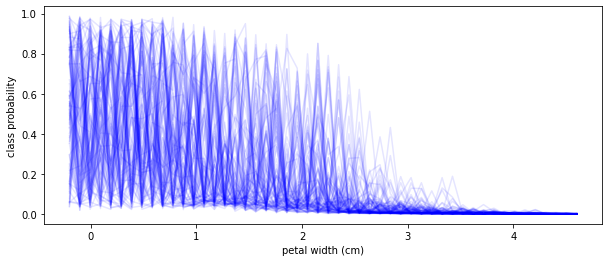

In [87]:
X_interval = np.linspace(-data.data[target_x,:].min(),data.data[target_x,:].max(), x_bins)
fig, ax = plt.subplots( facecolor="white", figsize=(10,4))

for c in range(1):
    for s in range(sampling_num):
        ICE = predictions[c,:,s]
        ax.plot(X_interval, ICE, c=["blue", "orange", "g"][c], alpha=0.1)

plt.xlabel(data.feature_names[target_x])
plt.ylabel("class probability")


## For all X features 

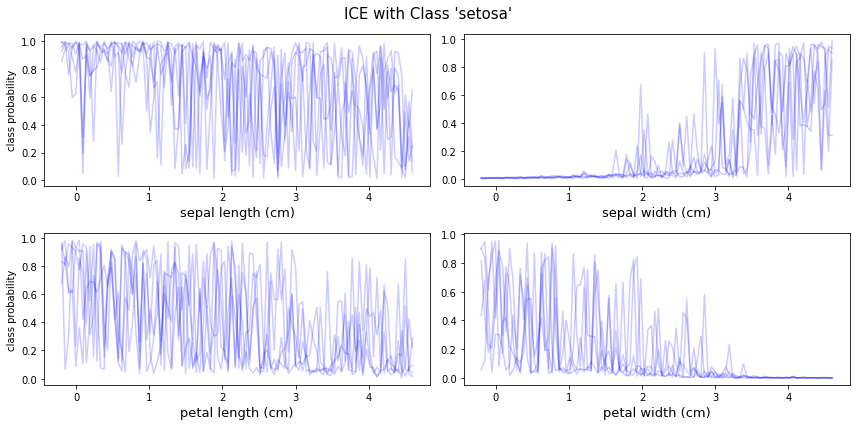

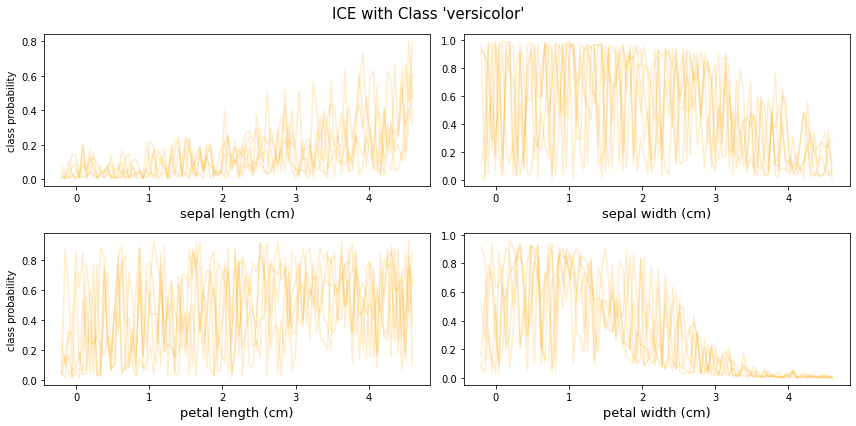

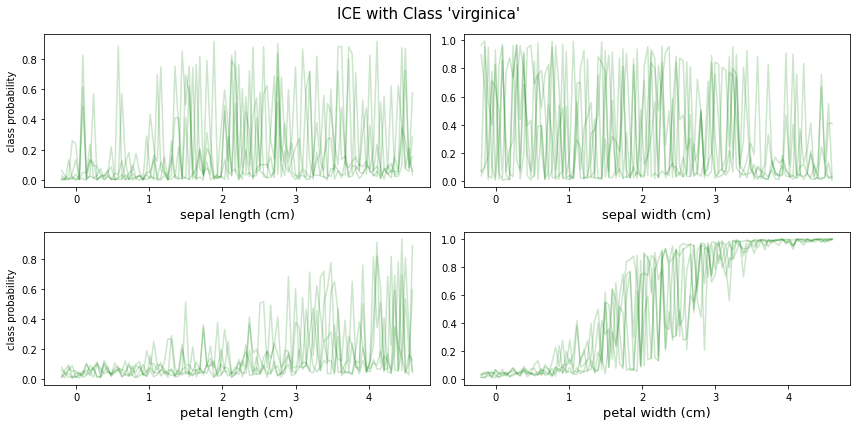

In [93]:

model.eval()

sampling_num = 5
x_bins = 100
predictions = np.zeros(shape=(3, 4, x_bins, sampling_num))
X_interval= np.linspace(-data.data[target_x,:].min(), data.data[target_x,:].max(), x_bins)

for target_x in range(4):
    for i, x in enumerate(X_interval):
        X = np.zeros(shape=(sampling_num, 4))
        for k in range(4):
            X[:,k] = np.random.choice(data.data[:, k], sampling_num)
        X[:, target_x] = x 
        
        X = torch.tensor(X, device=DEVICE).float()
        X = (X-torch.tensor(MEAN).to(DEVICE).float())/torch.tensor(STD).to(DEVICE).float()
        with torch.no_grad():
            Y = model.forward(X)
        classes = torch.softmax(Y[:,].cpu().detach(), -1).numpy()
        for c__ in range(3):
            predictions[c__,target_x,i,:] = classes[:,c__] 

for c in range(3):
    fig, axes = plt.subplots(2,2, facecolor="white", figsize=(12,6))
    axes  = axes.flat 
    fig.suptitle("ICE with Class '{0}'".format(data.target_names[c]), fontsize=15)
    for target_x in range(4):
        ax = next(axes)
        for s in range(sampling_num):
            ICE = predictions[c,target_x,:,s]
            ax.plot(X_interval, ICE, c=["blue", "orange", "g"][c], alpha=0.2)

        if target_x%2 ==0:
            ax.set_ylabel("class probability")
        ax.set_xlabel(data.feature_names[target_x], fontsize=13)
    plt.tight_layout()
